# Sprint13課題 深層学習スクラッチ畳み込みニューラルネットワーク2

In [1]:
#ライブラリのインポート
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
#(n_samples, n_channels, height, width)のNCHW
X_train = X_train.reshape(60000, 1, 28, 28)
X_test = X_test.reshape(10000, 1, 28, 28)

In [4]:
#float型へ
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

#正規化
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [5]:
#データ分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape)
print(X_val.shape)

(48000, 1, 28, 28)
(12000, 1, 28, 28)


## 【問題1】2次元畳み込み層の作成
Sprint12で作成した1次元畳み込み層を発展させ、2次元畳み込み層のクラスConv2dを作成してください。

フォワードプロパゲーションの数式は以下のようになります。
$$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$$


In [6]:
class Conv2d:
    """
    Parameters
    ----------
    n_filters : int
        フィルター数
    n_channel : int
        チャンネル数
    filter_h : int
        フィルターの高さ
    filter_w : int
        フィルターの幅
    optimizer : instance
        最適化手法
    stride : int
        ストライド数
    pad : int
        パディング数
    
    Attribute
    ------------
    self.weight : ndarray, shape(n_filters, n_channel, filter_h, filter_w)
        重み（フィルター）
    self.bias : ndarray, shpae(n_channel)
    
    """
    def __init__(self, n_filters, n_channel, filter_h, filter_w, optimizer, stride, pad):
        
        self.n_filters = n_filters
        self.n_channel = n_channel
        self.filter_h = filter_h
        self.filter_w = filter_w
        self.optimizer = optimizer
        self.stride = stride
        self.pad = pad
        
        self.weight = np.random.randn(n_filters, n_channel, filter_h, filter_w)
        self.bias = np.zeros(n_channel)
        

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_channels, height, width)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (n_samples, n_filters, out_h outw)
            出力
        """
        #バックワード用に保存
        self.forward_X = X.copy()
        
        #入力データのshape
        self.n, self.in_c, self.in_h, self.in_w = X.shape

        #2次元畳み込み後の出力サイズ
        self.out_h = output_size(self.in_h, self.filter_h, self.stride, self.pad)
        self.out_w = output_size(self.in_w, self.filter_w, self.stride, self.pad)

        #出力格納用の空箱
        A = np.zeros([self.n, self.n_filters, self.out_h, self.out_w])
        
        #2d_convlution
        for sample in range(self.n):
            #フィルター枚数分繰り返し
            for fil in range(self.n_filters):
                #チャンネル数分繰り返し
                for channel in range(self.in_c):
                    #縦のストライド
                    for h_conv in range(self.out_h):
                        #横のストライド
                        for w_conv in range(self.out_w):
                            #出力用の配列の対応要素に加算していく。
                            A[sample][fil][h_conv][w_conv] += np.sum(
                                X[sample][channel][h_conv:h_conv+self.filter_h, w_conv:w_conv+self.filter_w] 
                                * self.weight[fil][channel]) + self.bias[channel]
                   
        return A
    
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (n_samples, n_filters, out_h, out_w)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (n_samples, n_channels, height, width)
            前に流す勾配
        """
        #チャンネルを軸とした勾配合計
        self.dB = np.sum(dA, axis=(0,2,3))
        
        #deltaWの空箱
        self.dW = np.zeros(self.weight.shape)

        #deltaXの空箱
        dX = np.zeros([dA.shape[0], self.n_channel, self.in_h, self.in_w])
        
        #サンプル数
        for sample in range(dA.shape[0]):
            #チャンネル数
            for channel in range(self.n_channel):
                #フィルター数
                for filters in range(self.n_filters):
                    #縦の出力サイズ
                    for h_conv in range(self.out_h):
                        #横の出力サイズ
                        for w_conv in range(self.out_w):
                            #縦のフィルターサイズ
                            for h_filter in range(self.filter_h):
                                #横のフィルターサイズ
                                for w_filter in range(self.filter_w):

                                    #deltaWの対応要素へ加算していく
                                    self.dW[filters][channel][h_filter][w_filter] +=\
                                        dA[sample][filters][h_conv][w_conv] *\
                                        self.forward_X[sample][channel][h_conv+h_filter][w_conv+w_filter]
                                    
                                    #deltaXの対応要素に加算していく
                                    dX[sample][channel][h_conv+h_filter][w_conv+w_filter] +=\
                                        dA[sample][filters][h_conv][w_conv] *\
                                        self.weight[filters][channel][h_filter][w_filter]

                                    
        # 更新
        self = self.optimizer.update(self)
                      
        return dX
            



## 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。
$$
N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1\\
N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1
$$

In [7]:
def output_size(in_n, filter_hw, stride, pad):
    '''
    畳み込み後の出力サイズを計算する
    Parameters
    ----------
    in_n : int
        入力サイズ（特徴量の数）
    filter_hw : int
        フィルタのサイズ
    stride : int
        ストライドのサイズ
    pad : パディングのサイズ
    
    Return
    ---------
    out_n : int
         出力のサイズ（特徴量の数）
    
    '''

    out_n = int(((in_n + 2 * pad - filter_hw) / stride) + 1)

    return out_n

## 【問題3】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、フォワードプロパゲーションの数式は以下のようになります。

$$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$

In [8]:
class MaxPool2D:
    '''
    最大プーリング層
    Parameters
    ----------
    stride_h : int
        縦のストライドサイズ
    stride_w : int
        横のストライドサイズ
    
    Attribute
    -------------
    self.forwad_X : ndarray, shape (n_samples, n_channels, height, width)
        フォワード時の入力値データ（バックワード用）
    self.out_h : int
        プーリング時の出力時の高さ
    self.out_w : int
        プーリング時の出力時の幅
    self.pool_out_idx :  ndarray, shape (n_samples, n_filters, out_h, out_w)
        プーリング時の最大値インデックス
    '''
    
    def __init__(self, stride_h, stride_w):
        
        self.stride_h = stride_h
        self.stride_w = stride_w
    
        
    def forward(self, X):
        '''
        プーリングを行い、ダウンサンプリングする
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_channels, height, width)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (n_samples, n_filters, out_h, out_w)
            出力
        '''  
        #バックワード用にコピー
        self.forward_X = X.copy()
        
        #入力データのshape
        N, C , in_h, in_w = X.shape

        #出力サイズの計算
        self.out_h = int(in_h/self.stride_h)
        self.out_w = int(in_w/self.stride_w)

        #出力データ(プーリング結果)の空箱
        A = np.zeros([N, C, self.out_h, self.out_w])
        #プーリング時の最大値インデックス記憶する空箱
        self.pool_out_idx = np.zeros([N, C, self.out_h, self.out_w])
        
        for sample in range(N):
            for channel in range(C):
                for h_pool in range(self.out_h):
                    for w_pool in range(self.out_w):

                        #プーリング結果を出力配列に更新していく
                        A[sample][channel][h_pool][w_pool] = \
                            np.max(X[sample][channel]
                                   [h_pool*self.stride_h:(h_pool+1)*self.stride_h, w_pool*self.stride_w:(w_pool+1)*self.stride_w])

                        #プーリング時の最大値インデックスを記憶していく
                        self.pool_out_idx[sample][channel][h_pool][w_pool] = \
                            np.argmax(X[sample][channel]
                                      [h_pool*self.stride_h:(h_pool+1)*self.stride_h, w_pool*self.stride_w:(w_pool+1)*self.stride_w])
                        
        return A
    
    def backward(self, dA):
        '''
        プーリングのバックワード、アップサンプリングする
        Parameters
        ----------
        dA : 次の形のndarray, shape (n_samples, n_filters, out_h, out_w)
            後ろから流れてきた勾配
        Returns
        ----------
        dX : 次の形のndarray, shape (n_samples, n_channels, height, width)
            前に流す勾配
        '''
        #入力データのサンプル数、チャンネル数を確認
        N = dA.shape[0]
        C = dA.shape[1]
        
        #出力データの空箱を作成する
        dX = np.zeros(self.forward_X.shape)

        for sample in range(N):
            for channel in range(C):
                for h_pool in range(self.out_h):
                    for w_pool in range(self.out_w):
                        #最大値インデックスより、ストライド配列内の行を特定する
                        row = int(self.pool_out_idx[sample][channel][h_pool][w_pool] // self.stride_h)
                        
                        #最大値インデックスより、ストライド配列内の列を特定する
                        column = int(self.pool_out_idx[sample][channel][h_pool][w_pool] % self.stride_h)
                        
                        #フォワード前と同じインデックスのみに対して更新を行う
                        dX[sample][channel][h_pool*self.stride_h+row][w_pool*self.stride_w+column]\
                            = dA[sample][channel][h_pool][w_pool]
    
        
        
        return dX
        

## 【問題4】平滑化
平滑化するためのクラスFlatten()を作成してください。

フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。

In [9]:
class Flatten:
    '''
    平滑化を行う
    
    Parameters
    ----------
    None
    
    Attribute
    -------------
    self.f_c : int
        フォワード時の入力データチャンネル数
    self.f_h : int
        フォワード時の入力データ高さ
    self.f_w : int
        フォワード時の入力データ幅
    '''

    
    def __init__(self):
        self.f_c = None
        self.f_h = None
        self.f_w = None
    
    def forward(self, X):
        '''
        入力データに対して平滑化を行い、4次元→2次元にする
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_channels, height, width)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (n_samples, n_channels * height * width)
            出力
        '''  
        #入力データの形
        f_n, self.f_c, self.f_h, self.f_w = X.shape
        
        fX = X.reshape(f_n, self.f_c * self.f_h * self.f_w)
        
        return fX
        
        
    def backward(self, fX):
        '''
        フォワードにて平滑化された入力値のshapeを元に戻す
        Parameters
        ----------
        fxX : 次の形のndarray, shape (n_samples, n_channels * height * width)
            平滑化された入力値
        Returns
        ----------
        A : 次の形のndarray, shape (n_samples, n_channels, height, width)
            出力（元に戻す）
        '''  
        #サンプル数を確認
        b_n = fX.shape[0]
        
        #元の形に戻す
        rX = fX.reshape(b_n, self.f_c, self.f_h, self.f_w)
        
        return rX
    
    

## 【問題5】学習・推定
作成したConv2dを使用してMNISTの分類を学習・推定してください。

この段階では精度は気にせず、動くことを確認してください。

In [10]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    
    Attribute
    ------------
    self.W : 重み
    self.B : バイアス
    self.H_w : 前のイテレーションまでの勾配の(重み)二乗和(初期値0)
    self.H_b : 前のイテレーションまでの勾配の(バイアス)二乗和(初期値0)
    self.forward_Z : forward時の入力値(backward用に利用)
    self.dW : 重みの勾配
    self.dB : バイアスの勾配
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.weight = initializer.W(n_nodes1, n_nodes2)
        self.bias = initializer.B(n_nodes2)
                
        self.forward_Z=None

    def forward(self, Z):
        """
        フォワード
        Parameters
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        #backfoward用に保存
        self.forward_Z = Z.copy()
        
        A = (Z @ self.weight) + self.bias
        
        return A
    
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dB = dA.copy()
        self.dW = self.forward_Z.T @ dA
        
        #[batch_size, n_nodes2] dot [n_nodes2, n_nodes1]
        #→ [batch_size, n_nodes1]
        dZ = dA @ self.weight.T 
        
        # 更新
        self = self.optimizer.update(self)
              
        return dZ


In [11]:
class Relu():
    """
    ReLUの計算
    
    Parameters
    -----------
    
    Attribute
    -----------
    self.mask : 入力値の0以下を判定するboolリスト
    
    """
    
    def __init__(self):
        self.mask = None     
        
    def forward(self, A):
        """
        フォワードにおける活性化関数の計算
        
        Parameters
        -----------
        A : 活性化関数計算前
        
        Return
        -----------
        Z : 出力

        """
        self.mask = (A <= 0)
        
        Z = A.copy()
        
        Z[self.mask] = 0
        
        return Z
    
    def backward(self, dZ):
        """
        バックワードにおける活性化関数の計算
        
        Parameters
        -----------
        dZ : 活性化関数計算前
        
        Return
        -----------
        dA : 出力

        """        
        dA = dZ.copy()
        
        dA[self.mask] = 0
        
            
        return dA

In [12]:
class Softmax():
    """
    softmaxの計算
    
    Parameters
    -----------
    
    Attribute
    -----------
    self.cost : 交差エントロピー誤差を格納
    """
    
    def __init__(self):
        self.cost = None
        
    def forward(self, A):
        """
        フォワードにおけるソフトマックスの計算
        
        Parameters
        -----------
        A : 活性化関数計算前
        
        Return
        -----------
        Z : 出力
        """
        #オーバーフロー対策
        max_A = np.max(A)

        #最大要素を引いてからexpをかけることでオーバーフローを回避
        exp_A = np.exp(A - max_A)

         #分母を計算
        sum_exp_A = np.sum(exp_A, axis=1).reshape(-1, 1)
        
        Z = exp_A / sum_exp_A

        return Z
        
    
    def backward(self, Z, Y):
        """
        バックワードにおけるソフトマックスと交差エントロピー誤差
        
        Parameters
        -----------
        Z : 出力層で計算された出力
        Y : 正解値
        
        Return
        -----------
        dA : 出力

        """
        #交差エントロピー誤差
        self.cost = - np.sum(Y * np.log(Z), axis=1)

        #バックワード(出力層)
        dA = Z - Y
        
        return dA
    


In [13]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.weight -= self.lr * layer.dW / layer.dB.shape[0]
        layer.bias -= np.mean(self.lr * layer.dB, axis=0)
        
        return layer

In [14]:
class HeInitializer:
    """
    Heによる初期化
    
    Parameters
    ----------
    
    """
    
    def __init__(self):
        pass
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1) * np.sqrt(2)

        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.zeros(n_nodes2)

        return B

In [15]:
class Softmax():
    """
    softmaxの計算
    
    Parameters
    -----------
    
    Attribute
    -----------
    self.cost : 交差エントロピー誤差を格納
    """
    
    def __init__(self):
        self.cost = None
        
    def forward(self, A):
        """
        フォワードにおけるソフトマックスの計算
        
        Parameters
        -----------
        A : 活性化関数計算前
        
        Return
        -----------
        Z : 出力
        """
        #オーバーフロー対策
        max_A = np.max(A)

        #最大要素を引いてからexpをかけることでオーバーフローを回避
        exp_A = np.exp(A - max_A)

         #分母を計算
        sum_exp_A = np.sum(exp_A, axis=1).reshape(-1, 1)
        
        Z = exp_A / sum_exp_A

        return Z
        
    
    def backward(self, Z, Y):
        """
        バックワードにおけるソフトマックスと交差エントロピー誤差
        
        Parameters
        -----------
        Z : 出力層で計算された出力
        Y : 正解値
        
        Return
        -----------
        dA : 出力

        """
        #交差エントロピー誤差
        self.cost = - np.sum(Y * np.log(Z), axis=1)

        #バックワード(出力層)
        dA = Z - Y
        
        return dA
    


In [16]:
class Scratch2dCNNClassifier():
    """
    2次元畳み込みニューラルネットワーク
    (sgd)
    conv2d - relu - pooling - relu - FC - softmax

    Parameters
    ----------
    verbose : bool
        学習過程を出力する場合はTrue
    n_epochs : int(default:30)
        イテレーション数
    lr : flaot (default:1e-3)
        学習率
    batch : int(default :10)
        ミニバッチの単位数
    conv_n_filters : int(default:3)
        畳み込み時のフィルター枚数
    conv_n_channel : int(default:1)
        畳み込み時のチャンネル数
    conv_filter_h : int(default:3)
        畳み込み時のフィルターサイズ(縦)
    conv_filter_w : int(default:3)
        畳み込み時のフィルターサイズ(横)
    conv_stride : int(default:1)
        畳み込み時のストライド数
    conv_pad : int(default:0)
        畳み込み時のパディング数
    pool_stride_h : int(default:2)
        プーリング時のストライドサイズ(縦)
    pool_stride_w : int(default:2)
        プーリング時のストライドサイズ(横)

    Attributes
    ----------
    self.loss : ndarray,shape(n_epochs, )
        エポックごとの誤差を格納
    self.val_loss : ndarray,shape(n_epochs, )
        エポックごとの誤差(検証用データ)を格納
        
        
    """

    def __init__(self, verbose = True, n_epochs=10, lr=1e-3, batch=10, 
                 conv_n_filters=3, conv_n_channel=1, conv_filter_h=3, conv_filter_w=3, 
                 conv_stride=1, conv_pad=0, pool_stride_h=2, pool_stride_w=2):

        self.verbose = verbose                            #True(default):学習過程を表示、False:非表示
        self.n_epochs = n_epochs                       #エポック数(default:30)
        self.lr = lr                                               #学習率(default:1e-3)
        self.batch = batch                                  #ミニバッチを行うサイズ(default:10)
        self.conv_n_filters = conv_n_filters          #畳み込み時のフィルター枚数
        self.conv_n_channel = conv_n_channel   #畳み込み時のチャンネル数
        self.conv_filter_h = conv_filter_h            #畳み込み時のフィルターサイズ(縦)
        self.conv_filter_w = conv_filter_w           #畳み込み時のフィルターサイズ(横)
        self.conv_stride = conv_stride               #畳み込み時ストライド数
        self.conv_pad = conv_pad                     #畳み込み時のパディング数
        self.pool_stride_h = pool_stride_h          #プーリング時のストライド数(縦)
        self.pool_stride_w = pool_stride_w         #プーリング時のストライド数(横)

        self.loss = np.zeros(n_epochs)
        self.val_loss = np.zeros(n_epochs)
    
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        #出力層のアウトプットノード数
        self.n_output = np.unique(y).shape[0]
        
        #conv後の出力サイズ
        conv_out_h = int(((X.shape[2] + 2 * self.conv_pad - self.conv_filter_h) // self.conv_stride) + 1)
        conv_out_w = int(((X.shape[3] + 2 * self.conv_pad - self.conv_filter_w) // self.conv_stride) + 1)
        
        #pooling後の出力サイズ
        pool_out_h = int(conv_out_h // self.pool_stride_h)
        pool_out_w = int(conv_out_w // self.pool_stride_w)
        
        #出力層への入力サイズ
        n_node = self.conv_n_filters * pool_out_h * pool_out_w 
        
        #正解データをワンホットエンコーディング
        y = self._onehot(y)
        #検証用データもあればワンホット
        if X_val is not None:
            y_val = self._onehot(y_val)


        #入力層のノード数
        self.n_features = X.shape[1]

        #minibatchデータを生成
        train_minibatch = GetMiniBatch(X, y, batch_size=self.batch)
        

        #最適化手法のインスタンスを選択、生成。
        optimizer = SGD(self.lr)
        
        #活性化関数
        
        #1層目(conv2d)
        #インスタンス生成、重みの初期化
        self.conv2d = Conv2d(self.conv_n_filters, self.conv_n_channel, 
                         self.conv_filter_h, self.conv_filter_w, optimizer, self.conv_stride, self.conv_pad)
        self.activation1 = Relu()

        #pooling
        #インスタンス生成
        self.pool2d= MaxPool2D(self.pool_stride_h, self.pool_stride_w)
        self.activation2 = Relu()

        #3層目(全結合　出力層)
        #インスタンス生成、重みの初期化
        self.FC = FC(n_node, self.n_output, HeInitializer(), optimizer)
        self.activation3 = Softmax()
        
        #平滑化インスタンス生成
        self.fl = Flatten()

        #エポック数だけトレーニングを繰り返す
        for epoch in range(self.n_epochs):
                            
            #引数で設定したminibatch数の単位で学習を行う
            for mini_X, mini_y in train_minibatch:
                X = mini_X.copy()
                Y = mini_y.copy()
                                            
                #フォワードプロパゲーション
                A1 = self.conv2d.forward(X)
                Z1 = self.activation1.forward(A1)
                A2 = self.pool2d.forward(Z1)
                Z2 = self.activation2.forward(A2)
                Z2 = self.fl.forward(Z2)
                A3 = self.FC.forward(Z2)
                Z3 = self.activation3.forward(A3)
                                
                #バックプロパゲーション
                dA3 = self.activation3.backward(Z3, Y) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC.backward(dA3)
                dZ2 = self.fl.backward(dZ2)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.pool2d.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.conv2d.backward(dA1) # dZ0は使用しない
                    

            ############
            # 評価
            ############
            #誤差を格納
            self.loss[epoch] = np.mean(self.activation3.cost)
                        
            #検証用データが引数にある場合、処理を行う
            if X_val is not None:
                                
                #フォワードプロパゲーション
                A1_val = self.conv2d.forward(X_val)
                Z1_val = self.activation1.forward(A1_val)
                A2_val = self.pool2d.forward(Z1_val)
                Z2_val = self.activation2.forward(A2_val)
                Z2_val = self.fl.forward(Z2_val)
                A3_val = self.FC.forward(Z2_val)
                Z3_val = self.activation3.forward(A3_val)
                
                #検証用データの交差エントロピー誤差を計算
                cost_val = self._compute_cost(y_val, Z3_val)

                #誤差を格納
                self.val_loss[epoch] = np.mean(cost_val)
                            

            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose:
                #一度だけ、'Cross Entropy Error'を出力
                if epoch == 0:
                    print('Cross Entropy Error')
                    
                #エポックごとのコスト関数を出力
                print('epoch{} : {}'.format(epoch+1, np.mean(self.activation3.cost)))
                
                #検証用データがある場合、そのコスト関数も出力
                if X_val is not None:
                    print('epoch_val{} : {}'.format(epoch+1, np.mean(cost_val)))

        return self


    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
        y_pred :  次の形のndarray, shape (n_samples, 1)
            推定結果
        """        
        #フォワードプロパゲーション
        A1 = self.conv2d.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.pool2d.forward(Z1)
        Z2 = self.activation2.forward(A2)
        Z2 = self.fl.forward(Z2)
        A3 = self.FC.forward(Z2)
        Z3 = self.activation3.forward(A3)

        
        #出力層の確率から、最大値をそのクラスとする
        y_pred = np.argmax(Z3, axis=1)
        
        return y_pred
    
    def _onehot(self, y):
        """
        多クラス分類を行う際のone-hot表現に変換

        Parameters
        ----------
        y : 次の形のndarray, shape (n_samples, )
            サンプル

        Returns
        -------
        y_one_hot : 次の形のndarray, shape (n_samples, n_classes)
            推定結果
        """
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_one_hot = enc.fit_transform(y[:, np.newaxis])
        
        return y_one_hot
    
    
    #交差エントロピー誤差
    def _compute_cost(self, y, y_pred):

        return - np.sum(y * np.log(y_pred), axis=1)
    
    
    
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

### モデル作成・処理実行

In [17]:
s2dcnn = Scratch2dCNNClassifier(
    verbose = True, 
    n_epochs=10, 
    lr=1e-2, 
    batch=10, 
    conv_n_filters=3, 
    conv_n_channel=1, 
    conv_filter_h=3, 
    conv_filter_w=3, 
    conv_stride=1, 
    conv_pad=0, 
    pool_stride_h=2, 
    pool_stride_w=2)


In [18]:
#処理に時間がかかるため、入力データサンプル数を制限
s2dcnn.fit(X_train[0:150], y_train[0:150],X_val[0:100], y_val[0:100])

Cross Entropy Error
epoch1 : 1.8792808892795445
epoch_val1 : 2.0092951414783182
epoch2 : 1.3381469251285145
epoch_val2 : 1.5387780007642382
epoch3 : 0.9448946205477258
epoch_val3 : 1.2152281329533599
epoch4 : 0.6972450541119335
epoch_val4 : 1.002900872458563
epoch5 : 0.5314954061971527
epoch_val5 : 0.8688921893551241
epoch6 : 0.41161355283928847
epoch_val6 : 0.7808395818422897
epoch7 : 0.32373326981154454
epoch_val7 : 0.7186423990967385
epoch8 : 0.2616350359519199
epoch_val8 : 0.6739051716483163
epoch9 : 0.21687927858218145
epoch_val9 : 0.6413009074459205
epoch10 : 0.1842850601324563
epoch_val10 : 0.6169860806065747


 - for文の積み重なりのため、処理時間に時間かかるものの、目的関数(クロスエントロピー誤差)を低減させることができた

<function matplotlib.pyplot.show(*args, **kw)>

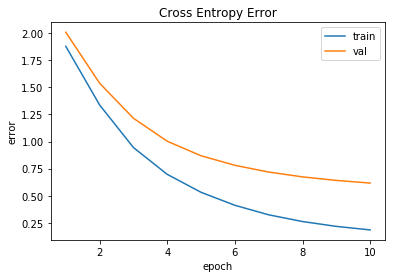

In [19]:
plt.plot(np.arange(1, len(s2dcnn.loss) + 1, 1), s2dcnn.loss, label='train')
plt.plot(np.arange(1, len(s2dcnn.val_loss) + 1, 1), s2dcnn.val_loss, label='val')


plt.title('Cross Entropy Error')
plt.xlabel('epoch')
plt.ylabel('error')

plt.legend()
plt.show

In [20]:
#サンプル数100にて精度を確認
print(classification_report(y_val[0:100], s2dcnn.predict(X_val[0:100])))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       1.00      0.84      0.91        19
           2       0.80      0.73      0.76        11
           3       0.89      0.73      0.80        11
           4       0.64      0.88      0.74         8
           5       0.89      0.89      0.89         9
           6       0.67      0.83      0.74        12
           7       1.00      1.00      1.00        12
           8       0.50      1.00      0.67         5
           9       0.67      0.33      0.44         6

   micro avg       0.81      0.81      0.81       100
   macro avg       0.80      0.79      0.78       100
weighted avg       0.84      0.81      0.81       100



## 【問題6】（アドバンス課題）LeNet
CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的です。

現在では実用的に使われることはありませんが、歴史的に重要なのは1998年のLeNetです。この構造を再現して動かしてみましょう。

*省略*

## 【問題7】（アドバンス課題）有名な画像認識モデルの調査
CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがあります。こういったものはフレームワークで既に用意されていることも多いです。

どういったものがあるか簡単に調べてまとめてください。名前だけでも見ておくと良いでしょう。

**参考**
[Applications - Keras Documentation](https://keras.io/ja/applications/)

- Xception  
Inceptionを改良した、畳み込み層を工夫してパラメータ数と計算量を減らす方法の１つ


- VGG16  
VGGチームが作った、畳み込み13層+全結合層3層 = 16層のニューラルネットワーク。Oxford大学の研究グループが提案し2014年のILSVRで好成績を収める。


- VGG19  
VGGチームが作った、畳み込み16層+全結合層3層 = 19層のニューラルネットワーク。VGG16をよりディープにした。


- ResNet50  
勾配消失の問題を発生させることなく、CNNを50層まで深くする手法。


- InceptionV3  
inceptionを改良し、少ないパラメータと42層のネットワークで学習できる。ILSVRC205において、画像分類２位。


- InceptionResNetV2
Inceptinoアーキテクチャに対して、ResNetの大きな特徴である残差関数を利用したネットワークモデル。


- MobileNet  
名前の通り、モバイル端末でも耐えうる性能を持つ。モデルのサイズが小さく、計算量・メモリも少ないなど、高い水準を持つネットワークモデル


- DenseNet  
ResNetと似た構造を持つネットワークモデル。ResNetと異なる点としては、ショートカットコネクション側でコンボリューションを行い、メインのレイヤーに統合する。


- NASNet  
従来のニューラルネットワークでは、事前に人間がニューラルネットワークの構造を設計して、ネットワークの重みを最適化するが、NASではニューラルネットワークの構造自体やパラメータを最適化したうえで、重みを最適化する。


- MobileNetV2  
残差ブロックでの入出力を逆さまにした構造をベースとしたネットワークモデル。


## 【問題8】（アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成してください。

範囲内の最大値ではなく、平均値を出力とするプーリング層です。

画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません

*省略*

## 【問題9】出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。

また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。

以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。

In [21]:
def output_size(in_n, filter_hw, stride, pad):
    '''
    畳み込み後の出力サイズを計算する
    Parameters
    ----------
    in_n : int
        入力サイズ（特徴量の数）
    filter_hw : int
        フィルタのサイズ
    stride : int
        ストライドのサイズ
    pad : パディングのサイズ
    
    Return
    ---------
    out_n : int
         出力のサイズ（特徴量の数）
    
    '''

    out_n = int(((in_n + 2 * pad - filter_hw) // stride) + 1)

    return out_n

1.
- 入力サイズ : 144×144, 3チャンネル
- フィルタサイズ : 3×3, 6チャンネル
- ストライド : 1
- パディング : なし


In [22]:
#基本サイズ設定
in_h = 144
in_w = 144
in_channel = 3
filter_h = 3
filter_w = 3
out_channel = 3
stride = 1
pad = 0

#縦サイズ
out_h = output_size(in_h, filter_h, stride, pad)
#幅サイズ
out_w = output_size(in_w, filter_w, stride, pad)

#パラメータ数
#filter_h * filter_w * in_channel * out_channel + バイアス(1チャンネルごとに1つ)
n_paramer = filter_h * filter_w * in_channel * out_channel + out_channel

print('出力サイズ(縦) : {}, (横) : {}'.format(out_h, out_w))
print('パラメータ数 : {}'.format(n_paramer))

出力サイズ(縦) : 142, (横) : 142
パラメータ数 : 84


2.

- 入力サイズ : 60×60, 24チャンネル
- フィルタサイズ : 3×3, 48チャンネル
- ストライド　: 1
- パディング : なし

In [23]:
#基本サイズ設定
in_h = 60
in_w = 60
in_channel = 24
filter_h = 3
filter_w = 3
out_channel = 48
stride = 1
pad = 0

#縦サイズ
out_h = output_size(in_h, filter_h, stride, pad)
#幅サイズ
out_w = output_size(in_w, filter_w, stride, pad)

#パラメータ数
#filter_h * filter_w * in_channel * out_channel + バイアス(1チャンネルごとに1つ)
n_paramer = filter_h * filter_w * in_channel * out_channel + out_channel

print('出力サイズ(縦) : {}, (横) : {}'.format(out_h, out_w))
print('パラメータ数 : {}'.format(n_paramer))

出力サイズ(縦) : 58, (横) : 58
パラメータ数 : 10416


3.

- 入力サイズ : 20×20, 10チャンネル
- フィルタサイズ: 3×3, 20チャンネル
- ストライド : 2
- パディング : なし

In [24]:
#基本サイズ設定
in_h = 20
in_w = 20
in_channel = 10
filter_h = 3
filter_w = 3
out_channel = 20
stride = 2
pad = 0

#縦サイズ
out_h = output_size(in_h, filter_h, stride, pad)
#幅サイズ
out_w = output_size(in_w, filter_w, stride, pad)

#パラメータ数
#filter_h * filter_w * in_channel * out_channel + バイアス(1チャンネルごとに1つ)
n_paramer = filter_h * filter_w * in_channel * out_channel + out_channel

print('出力サイズ(縦) : {}, (横) : {}'.format(out_h, out_w))
print('パラメータ数 : {}'.format(n_paramer))

出力サイズ(縦) : 9, (横) : 9
パラメータ数 : 1820


## 【問題10】（アドバンス課題）フィルタサイズに関する調査
畳み込み層にはフィルタサイズというハイパーパラメータがありますが、2次元畳み込み層において現在では3×3と1×1の使用が大半です。以下のそれぞれを調べたり、自分なりに考えて説明してください。

- 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由  
畳み込みの際にフィルタサイズ分の要素の重みの掛け算が足し込まれており、フィルタのサイズが大きくなることにより、ぼかしが強くなりすぎてしまうため。


- 高さや幅方向を持たない1×1のフィルタの効果  
1×1のフィルタにおいても学習を行うことにより、重み・バイアスの学習が対象のinputデータにおける重要な特徴に対して強く反応していくことができる。